In [2]:
from tqdm import tqdm
import tensorflow.compat.v1 as tf
import networkx as nx
from scipy.linalg import block_diag
from subprocess import call
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import re 
import time
import glob

tf.disable_v2_behavior()
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# mpl.rcParams.update({'font.size': 13})

W0424 00:13:50.338933 17368 deprecation.py:323] From D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:68: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


# LN only network

In [2]:
metadata = {}
metadata['n_n'] = 1+5*3             # number of neurons
metadata['p_n'] = 1                  # number of PNs
metadata['l_n'] = 5*3                  # number of LNs

metadata['fgaba_mat'] = block_diag(np.array([[0]]),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)))
np.fill_diagonal(metadata['fgaba_mat'],0)

metadata['g_gaba'] = 1.2
metadata['sim_res'] = 0.01
n_syn_fgaba = int(metadata['fgaba_mat'].sum())
n_syn_sgaba = 0
n_syn_ach = 0

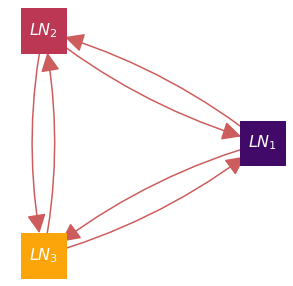

In [3]:
plt.figure(figsize=(5,5))
colors = plt.cm.inferno(np.linspace(0.2,0.8,3))
G= nx.from_numpy_matrix(metadata['fgaba_mat'][1:4,:][:,1:4],create_using=nx.DiGraph)
pos = nx.layout.circular_layout(G)

M = G.number_of_edges()

nodes = nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=[colors[0],colors[1],colors[2]],nodelist=[0,1,2],node_shape='s')
edges = nx.draw_networkx_edges(G, pos, node_size=2000, arrowstyle='-|>',
                               arrowsize=40, width=1.5,connectionstyle='arc3, rad=0.1',edge_color='indianred')
nx.draw_networkx_labels(G,pos,{0:r"$LN_1$",1:r"$LN_2$",2:r"$LN_3$"},font_size=16,font_color='white')
ax = plt.gca()
ax.set_axis_off()
plt.savefig('Figures/LN_only_graph.svg')
plt.show()

In [45]:
np.random.seed(74932)
samplespace = [[0]+[1,0,0]*5,[0]+[0,1,0]*5,[0]+[0,0,1]*5]
v = [[0]+[0,0,0]*5]
order = np.random.choice(np.arange(3), size=9)
while np.any(np.diff(order)==0):
    order = np.random.choice(np.arange(3), size=9)
for i in order:
    v.append(samplespace[i])
v = np.array(v)
blocktime = 1000 # in ms
buffer = 500 # in ms
sim_res = metadata['sim_res'] # simulation resolution (in ms)

In [5]:
width = int(blocktime/sim_res)
tfilter_base = np.ones(width)
width_red = int(0.1*blocktime/sim_res)
tfilter = np.zeros_like(tfilter_base)
tfilter[:width_red] = 1

In [6]:
sim_time = len(v)*blocktime + 2*buffer # total simulation time (in ms)
t = np.arange(0,sim_time,sim_res)        # duration of simulation

In [7]:
current_input = np.ones((metadata['n_n'],t.shape[0]-int(2*buffer/sim_res)))

In [8]:
for i in range(len(v)):
    current_input[:,i*width:(i+1)*width]=0.0735*current_input[:,i*width:(i+1)*width]*tfilter_base
    current_input[:,i*width:(i+1)*width]+= 0.15*(current_input[:,i*width:(i+1)*width].T*v[i]).T*tfilter

In [9]:
current_input = np.concatenate([np.zeros((current_input.shape[0],int(buffer/sim_res))),current_input,np.zeros((current_input.shape[0],int(buffer/sim_res)))],axis=1)

In [10]:
current_input += 0.05*current_input*np.random.normal(size=current_input.shape)+ 0.001*np.random.normal(size=current_input.shape)

In [11]:
state_vector =  [-45]* metadata['p_n']+[-45]* metadata['l_n'] + [0.5]* (metadata['n_n'] + 4*metadata['p_n'] + 3*metadata['l_n']) + [2.4*(10**(-4))]*metadata['l_n'] + [0]*(n_syn_ach+n_syn_fgaba+2*n_syn_sgaba) + [-(sim_time+1)]*metadata['n_n']
state_vector = np.array(state_vector)
state_vector = state_vector + 0.005*state_vector*np.random.normal(size=state_vector.shape)

In [12]:
np.save('__simcache__/metadata.npy',metadata,allow_pickle=True)

In [13]:
np.save('__simcache__/state_vector',state_vector)
np.save('__simcache__/current_input',current_input)
np.save('__simcache__/time',np.array_split(t,2*(len(v)+1)))

In [14]:
for i in tqdm(range(2*(len(v)+1))):
    call(['python','simple5x3.py',str(i)])

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [30:00<00:00, 81.83s/it]


In [15]:
dataset = []
files = os.listdir('__simoutput__/')
files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
for i in files:
    dataset.append(np.load(f'__simoutput__/{i}'))

In [16]:
dataset = np.concatenate(dataset)[:,:16]

In [17]:
rorder = np.random.choice(np.arange(5),replace=False,size=5)
order_rep = np.concatenate([np.arange(1,16,3,dtype=np.int64)[rorder],np.arange(2,16,3,dtype=np.int64)[rorder],np.arange(3,16,3,dtype=np.int64)[rorder]])
temp = dataset[:,order_rep]
fire = np.logical_and(temp[:-1,:]<-20,temp[1:,:]>-20)
events = []
for i in range(fire.shape[1]):
    events.append(np.arange(temp.shape[0])[:-1][fire[:,i]])
events = np.array(events,dtype=object)

In [4]:
if not os.path.exists("Data/LN_only_events.npy"):
    np.save("Data/LN_only_events.npy",events)
    np.save("Data/LN_only_dataset.npy",dataset)
    np.save("Data/LN_only_current.npy",current_input)
    files = glob.glob('__simcache__/*')
    for f in files:
        os.remove(f)
    files = glob.glob('__simoutput__/*')
    for f in files:
        os.remove(f)
events = np.load("Data/LN_only_events.npy",allow_pickle=True)
dataset = np.load("Data/LN_only_dataset.npy",allow_pickle=True)
current_input = np.load("Data/LN_only_current.npy",allow_pickle=True)

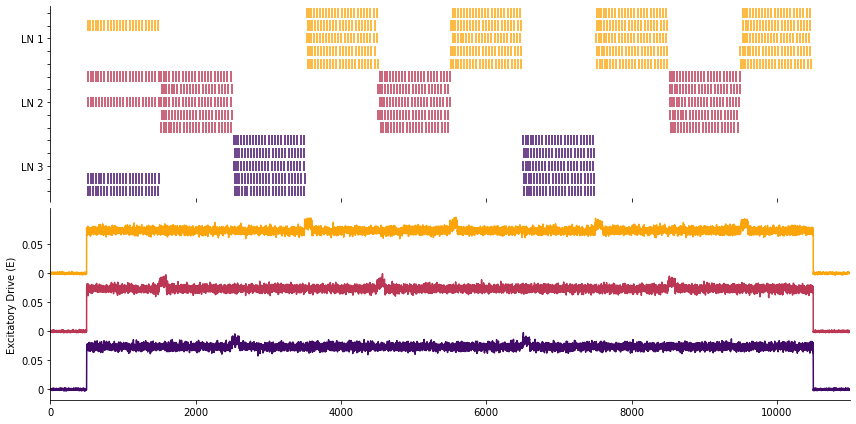

In [5]:
colors = plt.cm.inferno(np.linspace(0.2,0.8,3))
fig, ax = plt.subplots(2,1,sharex=True,figsize=(12,6))
ax[0].eventplot(events,linelengths=0.8,color=[colors[0]]*5+[colors[1]]*5+[colors[2]]*5)
ax[0].set_xlim(0,11000)
ax[0].set_ylim(-0.5,14.5)

for i in range(1,4):
    ax[1].plot(0.1*(i-1)+current_input[i,:],color=colors[i-1])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

ax[0].set_yticks(np.arange(15))
ax[0].set_yticklabels(['','','LN 3','','','','','LN 2','','','','','LN 1','',''])

ax[1].set_yticks(np.arange(0,0.30,0.05))
ax[1].set_yticklabels(['0','0.05','0','0.05','0','0.05'])
ax[1].set_ylabel("Excitatory Drive (E)")
plt.tight_layout()
plt.savefig('Figures/Fig_LN_only.svg')
plt.show()

# PN driven LN network

In [6]:
metadata = {}
metadata['n_n'] = 5*3+5*3             # number of neurons
metadata['p_n'] = 5*3                  # number of PNs
metadata['l_n'] = 5*3                  # number of LNs

metadata['fgaba_mat'] = block_diag(np.zeros((metadata['p_n'],metadata['p_n'])),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)),np.ones((metadata['l_n']//5,metadata['l_n']//5)))
np.fill_diagonal(metadata['fgaba_mat'],0)
metadata['fgaba_mat'][:metadata['p_n'],metadata['l_n']:] = metadata['fgaba_mat'][metadata['l_n']:,metadata['l_n']:]

metadata['sgaba_mat'] = metadata['fgaba_mat']

metadata['ach_mat'] = np.zeros_like(metadata['fgaba_mat'])
metadata['ach_mat'][metadata['p_n']:,:metadata['l_n']] = np.eye(metadata['p_n'])

metadata['sim_res'] = 0.01
n_syn_fgaba = int(metadata['fgaba_mat'].sum())
n_syn_sgaba = int(metadata['fgaba_mat'].sum())
n_syn_ach = int(metadata['ach_mat'].sum())

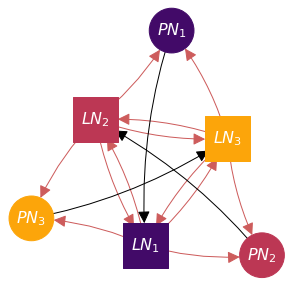

In [7]:
np.random.seed(48430)
colors = plt.cm.inferno(np.linspace(0.2,0.8,3))

plt.figure(figsize=(5,5))
G = nx.from_numpy_matrix((metadata['fgaba_mat'][[0,1,2,15,16,17],:][:,[0,1,2,15,16,17]]+metadata['ach_mat'][[0,1,2,15,16,17],:][:,[0,1,2,15,16,17]]).T,create_using=nx.DiGraph)

m1 = metadata['fgaba_mat'][[0,1,2,15,16,17],:][:,[0,1,2,15,16,17]].T
edges1 = []
for i in range(6):
    for j in range(6):
        if m1[i,j]:
            edges1.append((i,j))

m2 = metadata['ach_mat'][[0,1,2,15,16,17],:][:,[0,1,2,15,16,17]].T
edges2 = []
for i in range(6):
    for j in range(6):
        if m2[i,j]:
            edges2.append((i,j))

pos = nx.layout.fruchterman_reingold_layout(G)

M = G.number_of_edges()
0
nodes = nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=[colors[0],colors[1],colors[2]],nodelist=[0,1,2],node_shape='o')
nodes = nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=[colors[0],colors[1],colors[2]],nodelist=[3,4,5],node_shape='s')
edges = nx.draw_networkx_edges(G, pos, node_size=2000, arrowstyle='-|>',
                               arrowsize=25, width=1,connectionstyle='arc3, rad=0.1',edgelist=edges1,edge_color='indianred')
edges = nx.draw_networkx_edges(G, pos, node_size=2000, arrowstyle='-|>',
                               arrowsize=25, width=1,connectionstyle='arc3, rad=0.1',edgelist=edges2)
nx.draw_networkx_labels(G,pos,{0:r"$PN_1$",1:r"$PN_2$",2:r"$PN_3$",3:r"$LN_1$",4:r"$LN_2$",5:r"$LN_3$"},font_size=16,font_color='white')

ax = plt.gca()
ax.set_axis_off()
plt.savefig('Figures/LN_PN_graph.svg')
plt.show()

## Transient Perturbations (Random Sequences)

In [24]:
np.random.seed(8204491)
samplespace = [[0.31,0,0]*5,[0,0.31,0]*5,[0,0,0.31]*5]
v = []
order = np.random.choice(np.arange(3), size=10)
while np.any(np.diff(order)==0):
    order = np.random.choice(np.arange(3), size=10)
for i in order:
    v.append(samplespace[i])
v = np.array(v)
blocktime = 1000 # in ms
buffer = 500 # in ms
sim_res = metadata['sim_res'] # simulation resolution (in ms)

In [25]:
width = int(blocktime/sim_res)
tfilter_base = np.ones(width)
width_red = int(0.8*blocktime/sim_res)
tfilter = np.concatenate([[0,0],1-np.exp(-0.0008*np.arange(width_red//12)),0.6+0.4*np.exp(-0.0002*np.arange(7*width_red//12)),0.6*np.exp(-0.0002*np.arange(width_red//3)),np.zeros(int(blocktime/sim_res)//5)])

In [26]:
sim_time = len(v)*blocktime + 2*buffer # total simulation time (in ms)
t = np.arange(0,sim_time,sim_res)        # duration of simulation

In [27]:
current_input = np.ones((metadata['n_n'],t.shape[0]-int(2*buffer/sim_res)))

In [28]:
for i in range(len(v)):
    current_input[:metadata['p_n'],i*width:(i+1)*width] = (current_input[:metadata['p_n'],i*width:(i+1)*width].T*v[i]).T*tfilter
    current_input[metadata['p_n']:,i*width:(i+1)*width] = 0.0735*current_input[metadata['p_n']:,i*width:(i+1)*width]*tfilter_base

In [29]:
current_input = np.concatenate([np.zeros((current_input.shape[0],int(buffer/sim_res))),current_input,np.zeros((current_input.shape[0],int(buffer/sim_res)))],axis=1)

In [30]:
current_input += 0.05*current_input*np.random.normal(size=current_input.shape)+ 0.001*np.random.normal(size=current_input.shape)

In [31]:
state_vector =  [-45]* metadata['p_n']+[-45]* metadata['l_n'] + [0.5]* (metadata['n_n'] + 4*metadata['p_n'] + 3*metadata['l_n']) + [2.4*(10**(-4))]*metadata['l_n'] + [0]*(n_syn_ach+n_syn_fgaba+2*n_syn_sgaba) + [-(sim_time+1)]*metadata['n_n']
state_vector = np.array(state_vector)
state_vector = state_vector + 0.005*state_vector*np.random.normal(size=state_vector.shape)

In [32]:
np.save('__simcache__/metadata.npy',metadata,allow_pickle=True)

In [33]:
np.save('__simcache__/state_vector',state_vector)
np.save('__simcache__/current_input',current_input)
np.save('__simcache__/time',np.array_split(t,2*(len(v)+1)))

In [34]:
for i in tqdm(range(2*(len(v)+1))):
    call(['python','simple5x3pn.py',str(i)])

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [38:21<00:00, 104.62s/it]


In [35]:
dataset = []
files = os.listdir('__simoutput__/')
files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])
for i in files:
    dataset.append(np.load(f'__simoutput__/{i}'))

In [36]:
dataset = np.concatenate(dataset)[:,:30]

In [37]:
order_rep_LN = np.concatenate([np.arange(15,30,3,dtype=np.int64),np.arange(16,30,3,dtype=np.int64),np.arange(17,30,3,dtype=np.int64)])

In [38]:
temp_LN = dataset[:,order_rep_LN]
fire_LN = np.logical_and(temp_LN[:-1,:]<-20,temp_LN[1:,:]>-20)
events_LN = []
for i in range(fire_LN.shape[1]):
    events_LN.append(np.arange(temp_LN.shape[0])[:-1][fire_LN[:,i]])
events_LN = np.array(events_LN,dtype=object)

In [39]:
order_rep_PN = np.concatenate([np.arange(0,15,3,dtype=np.int64),np.arange(1,15,3,dtype=np.int64),np.arange(2,15,3,dtype=np.int64)])

In [40]:
temp_PN = dataset[:,order_rep_PN]
fire_PN = np.logical_and(temp_PN[:-1,:]<0,temp_PN[1:,:]>0)
events_PN = []
for i in range(fire_PN.shape[1]):
    events_PN.append(np.arange(temp_PN.shape[0])[:-1][fire_PN[:,i]])
events_PN = np.array(events_PN,dtype=object)

In [8]:
if not os.path.exists("Data/LN_PN_events_PN.npy"):
    np.save("Data/LN_PN_events_PN.npy",events_PN)
    np.save("Data/LN_PN_events_LN.npy",events_LN)
    np.save("Data/LN_PN_dataset.npy",dataset)
    np.save("Data/LN_PN_current.npy",current_input)
    files = glob.glob('__simcache__/*')
    for f in files:
        os.remove(f)
    files = glob.glob('__simoutput__/*')
    for f in files:
        os.remove(f)
events_PN = np.load("Data/LN_PN_events_PN.npy",allow_pickle=True)
events_LN = np.load("Data/LN_PN_events_LN.npy",allow_pickle=True)
dataset = np.load("Data/LN_PN_dataset.npy",allow_pickle=True)
current_input = np.load("Data/LN_PN_current.npy",allow_pickle=True)

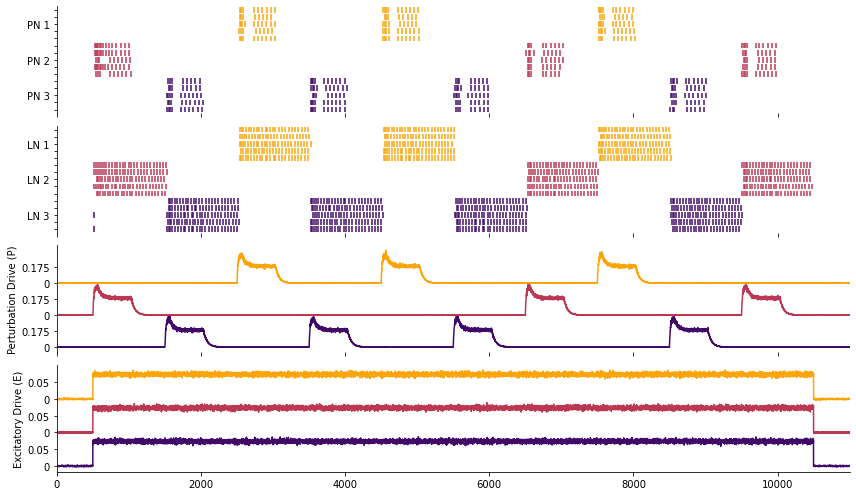

In [12]:
colors = plt.cm.inferno(np.linspace(0.2,0.8,3))
fig, ax = plt.subplots(4,1,sharex=True,figsize=(12,7))

ax[1].eventplot(events_LN,linelengths=0.8,color=[colors[0]]*5+[colors[1]]*5+[colors[2]]*5)
ax[1].set_xlim(0,11000)
ax[1].set_ylim(-0.5,14.5)

ax[0].eventplot(events_PN,linelengths=0.8,color=[colors[0]]*5+[colors[1]]*5+[colors[2]]*5)
ax[0].set_xlim(0,11000)
ax[0].set_ylim(-0.5,14.5)

for i in range(3):
    ax[2].plot(0.35*i+current_input[i,:],color=colors[i])
for i in range(15,18):
    ax[3].plot(0.1*(i-15)+current_input[i,:],color=colors[i-15])

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['bottom'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)

ax[1].set_yticks(np.arange(15))
ax[1].set_yticklabels(['','','LN 3','','','','','LN 2','','','','','LN 1','',''])

ax[0].set_yticks(np.arange(15))
ax[0].set_yticklabels(['','','PN 3','','','','','PN 2','','','','','PN 1','',''])

ax[2].set_yticks(np.arange(0,3*0.35,0.35/2))
ax[2].set_yticklabels(['0','0.175','0','0.175','0','0.175'])
ax[2].set_ylabel("Perturbation Drive (P)")

ax[3].set_yticks(np.arange(0,0.3,0.05))
ax[3].set_yticklabels(['0','0.05','0','0.05','0','0.05'])
ax[3].set_ylabel("Excitatory Drive (E)")

plt.tight_layout()
plt.savefig('Figures/Fig_LN_PN.svg')
plt.show()

In [3]:
temp = np.load(f'../modules/matrix_2.npy')
np.fill_diagonal(temp,0)

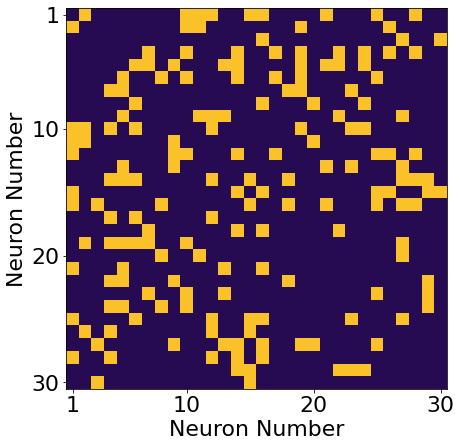

In [6]:
plt.figure(figsize=(7,7))
mpl.rcParams.update({'font.size': 22})
plt.imshow(temp,aspect='equal',cmap=plt.cm.inferno)
plt.clim(-0.2,1.2)
plt.xticks([0,9,19,29],[1,10,20,30])
plt.xlabel('Neuron Number')
plt.yticks([0,9,19,29],[1,10,20,30])
plt.ylabel('Neuron Number')
plt.savefig("Figures/LN_only_connectivity_2.svg")